## Generating simple Markowitz efficient frontier

#### 1) Import libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### 2) Extract Yahoo Finance stock data of sample tickers
* Sample year for portfolio return and volatility calculations: 2020

In [2]:
year = 2020
tickers = ['UBER', 'VIVHY', 'LYFT', 'IMO', 'JAPSY', 'CRLBF', 'SONY']
tickers2 = ' '.join(tickers)

now = datetime.now()
to_date = now.strftime('%Y-%m-%d')
from_date = (now - relativedelta(days=252*2)).strftime('%Y-%m-%d')

data = yf.download(tickers2, start=from_date, end=to_date)
close = data.loc[:, ('Close')]

year = 2020
close = close[close.index.year == year]

[*********************100%***********************]  7 of 7 completed


#### 3) Calculate basic portfolio metrics
* num of working/business days (assumed to be equal to trading days) (bus_days) - note: not all stocks may be traded for the full 250 trading days; thus, # of days calculated as start and end period of the dataset
* initial weights (init_weights):  randomized asset allocation weights for portfolio
* portfolio return (port_ret)
* portfolio covariance matrix (covar-matrix) - multiplied with bus_days to get equivalency covariance period
* portfolio variance (port_var)
* portfolio standard deviation/volatility (port_std)

In [3]:
bus_days = np.busday_count(close.index[0].date(), close.index[-1].date())
returns = close.pct_change()

init_weights = np.random.rand(returns.shape[1])
init_weights /= init_weights.sum()

port_ret = returns.dot(init_weights)
covar_matrix = returns.cov() * bus_days

port_var = np.transpose(init_weights) @ covar_matrix @ init_weights
port_std = np.sqrt(port_var)

#### 4) Generate portfolio returns/volatility from randomized asset allocations

In [4]:
drawn_ret, drawn_vol, drawn_weight = list(), list(), list()
num_assets = len(close.columns)
num_port = 10000 # num of samples to generate

# individ_returns = close.resample('D').last().dropna().pct_change().mean() * bus_days
individ_returns = (1 + close.resample('D').last().dropna().pct_change().mean())**bus_days - 1

for port in tqdm(range(num_port), desc='Processing sampling calculations'):
    weights = np.random.random(num_assets)
    weights /= weights.sum()
    drawn_weight.append(weights)
    rets = np.dot(weights, individ_returns)
    drawn_ret.append(rets)
    var = covar_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    ann_sd = np.sqrt(var) * np.sqrt(bus_days)
    drawn_vol.append(ann_sd)

Processing sampling calculations: 100%|████████████████████████████████████████| 10000/10000 [00:07<00:00, 1275.26it/s]


#### 5) Calculate global minimum variance portfolio & optimum Sharpe ratio portfolio

In [5]:
data2 = {'Portfolio Returns': drawn_ret, 'Portfolio Volatility': drawn_vol}
for i, symbol in enumerate(close.columns.tolist()):
    data2['w_{}'.format(symbol)] = [w[i] for w in drawn_weight]

portfolios_drawn = pd.DataFrame(data2)

# risk-free rate
rf = 0.01
# global minimum variance portfolio
min_vol_port = portfolios_drawn.iloc[portfolios_drawn['Portfolio Volatility'].idxmin()]
# optimum Sharpe ratio portfolio
opt_sr = portfolios_drawn.iloc[(
    (portfolios_drawn['Portfolio Returns'] - rf) / portfolios_drawn['Portfolio Volatility']).idxmax()]

#### 6) Estimate high return curvature points for approximate efficient frontier (aesthetic purposes)

In [6]:
sorted_portfolios_drawn = portfolios_drawn.sort_values('Portfolio Volatility').reset_index(drop=True)

ret_0 = min_vol_port[0]
idx_list = list()
for i, row in sorted_portfolios_drawn.iterrows():
    if row[0] > ret_0:
        idx_list.append(i)
        ret_0 = row[0]
        
high_ret_points = sorted_portfolios_drawn.loc[idx_list, :]

#### 7) Generate efficient frontier plot
* Red star indicates global minimum variance portfolio
* Blue star indicates optimal Sharpe ratio portfolio (presumed to be on the efficient frontier though not indicated in the below graph)
* Curve represents approximate fitted efficient frontier

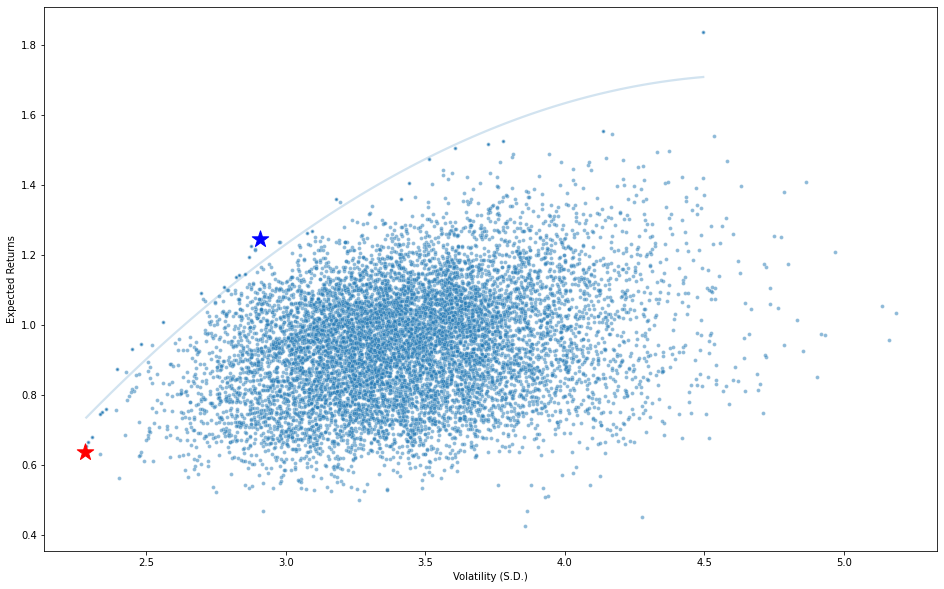

In [7]:
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.scatterplot(data=portfolios_drawn, 
                     x='Portfolio Volatility', 
                     y='Portfolio Returns', 
                     marker='o', 
                     alpha=0.5, 
                     s=15)
sns.regplot(data=high_ret_points, x='Portfolio Volatility', y='Portfolio Returns', order=2, ci=None, scatter_kws={"s": 1}, line_kws={'alpha': 0.2})
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=300)
plt.scatter(opt_sr[1], opt_sr[0], color='b', marker='*', s=300)
ax.set_xlabel('Volatility (S.D.)')
ax.set_ylabel('Expected Returns');